# FactoryML

## Hardware

In [17]:
!nvidia-smi

Sun Feb 23 19:47:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 570.86.16      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P0             21W /  115W |    6286MiB /   8188MiB |     15%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Imports

In [18]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import pandas as pd
import numpy as np
import keras
print("Keras version: ", keras.__version__)
from keras import layers
from matplotlib import pyplot as plt

Keras version:  3.8.0


## Loading data

### Columns

For furnace:
- DateTime - timestamp of the data
- ActivePower - power draw of the furnace
- ReactivePower - reactive power draw of the furnace
- MetalOutputIntensity - intensity of the metal output
- FurnacePodTemparature - temperature of the furnace pod
- FurnaceBathTemperature - temperature of the furnace bath
- PowerSetpoint - power setpoint of the furnace

For specific electrodes:
- ReleaseAmountA - how much graphite electrode is exposed to the furnace for electrode A
- ReleaseAmountB - how much graphite electrode is exposed to the furnace for electrode B
- ReleaseAmountC - how much graphite electrode is exposed to the furnace for electrode C
- UpperRingRaiseA - how much the upper ring is raised for electrode A
- UpperRingRaiseB - how much the upper ring is raised for electrode B
- UpperRingRaiseC - how much the upper ring is raised for electrode C
- UpperRingReleaseA - how much the upper ring is released for electrode A
- UpperRingReleaseB - how much the upper ring is released for electrode B
- UpperRingReleaseC - how much the upper ring is released for electrode C
- GasPressureUnderFurnaceA - gas pressure under the furnace for electrode A
- GasPressureUnderFurnaceB - gas pressure under the furnace for electrode B
- GasPressureUnderFurnaceC - gas pressure under the furnace for electrode C
- PowerA - power draw of the furnace for electrode A
- PowerB - power draw of the furnace for electrode B
- PowerC - power draw of the furnace for electrode C
- HighVoltageA - high voltage on electrode A
- HighVoltageB - high voltage on electrode B
- HighVoltageC - high voltage on electrode C
- LowerRingReleaseA - how much the lower ring is released for electrode A
- LowerRingReleaseB - how much the lower ring is released for electrode B
- LowerRingReleaseC - how much the lower ring is released for electrode C
- VentialtionValveForMantelA - ventilation valve of mantel for electrode A
- VentialtionValveForMantelB - ventilation valve of mantel for electrode B
- VentialtionValveForMantelC - ventilation valve of mantel for electrode C
- VoltageStepA - voltage step for electrode A
- VoltageStepB - voltage step for electrode B
- VoltageStepC - voltage step for electrode C
- CurrentHolderPositionA - current holder position for electrode A
- CurrentHolderPositionB - current holder position for electrode B
- CurrentHolderPositionC - current holder position for electrode C
- HolderModeA - holder mode for electrode A (automatic or manual)
- HolderModeB - holder mode for electrode B (automatic or manual)
- HolderModeC - holder mode for electrode C (automatic or manual)
- AirTemperatureMantelA - air temperature for electrode A
- AirTemperatureMantelB - air temperature for electrode B
- AirTemperatureMantelC - air temperature for electrode C

In [19]:
df = pd.read_csv(
    './data/dataset.csv', 
    index_col='DateTime', 
    parse_dates=True)

df_test = pd.read_csv(
    './data/dataset_test.csv', 
    index_col='DateTime', 
    parse_dates=True)

# decompose datetime to year, month, day, hour, minute, dayofweek
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['dayofweek'] = df.index.dayofweek

TIME_STEPS = 60
RECORD_PER_DAY = 60 * 24
DAYS_TO_COVER = 1

df = df.head(RECORD_PER_DAY * DAYS_TO_COVER)
df_test = df_test.head(RECORD_PER_DAY * DAYS_TO_COVER)

df = df[['MetalOutputIntensity']]
df_test = df_test[['MetalOutputIntensity']]
# df.reset_index(drop=True, inplace=True)

df.head()

,MetalOutputIntensity
DateTime,
2025-01-13 00:00:00+00:00,0.6188
2025-01-13 00:01:00+00:00,0.6188
2025-01-13 00:02:00+00:00,0.6188
2025-01-13 00:03:00+00:00,0.6188
2025-01-13 00:04:00+00:00,0.6188


# Preprocessing

In [20]:
# replace missing values with the median
df.fillna(df.median(), inplace=True)
df_test.fillna(df_test.median(), inplace=True)

# remove outliers
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df_test = df_test[(np.abs(stats.zscore(df_test)) < 3).all(axis=1)]

# normalize the data
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled = df

## Visualize

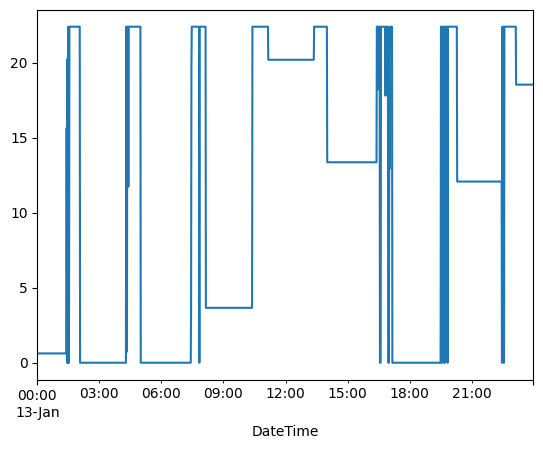

In [21]:
fig, ax = plt.subplots()
df_scaled.plot(legend=False, ax=ax)
plt.show()


# Learning

In [22]:
training_mean = df_scaled.mean()
training_std = df_scaled.std()
df_training_value = (df_scaled - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 1440


In [23]:
from utils import create_sequences

x_train = create_sequences(df_training_value.values, TIME_STEPS)
# fill the missing values with median
x_train = np.nan_to_num(x_train, nan=np.nanmedian(x_train))
print("Training input shape: ", x_train.shape)


Training input shape:  (1381, 60, 1)


In [24]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 30, 32)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 15, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 30, 16)         │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 60, 32)         │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 60, 1)          │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

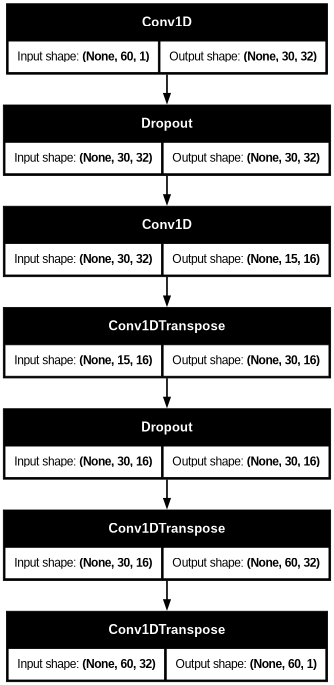

In [25]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)

In [26]:
history = model.fit(
    x_train,
    x_train,
    epochs=25,
    batch_size=256,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 429ms/step - loss: 1.0061 - val_loss: 0.4373
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7766 - val_loss: 0.1736
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4618 - val_loss: 0.1916
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2617 - val_loss: 0.1297
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2444 - val_loss: 0.1284
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1891 - val_loss: 0.1334
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1919 - val_loss: 0.1253
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1758 - val_loss: 0.1210
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1623 - val_loss: 0.1199
Epoch 10/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1606 - val_loss: 0.1186
Epoch 11/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1508 - val_loss: 0.1125
Epoch 12/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1431 - val_loss: 0.1097


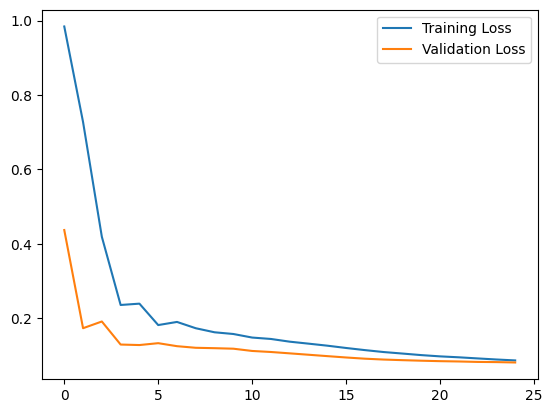

In [27]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


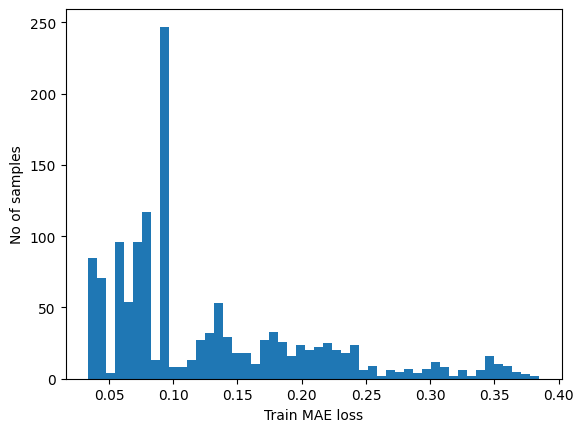

Reconstruction error threshold:  0.17704001104749154


In [28]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.percentile(train_mae_loss, 75)
print("Reconstruction error threshold: ", threshold)

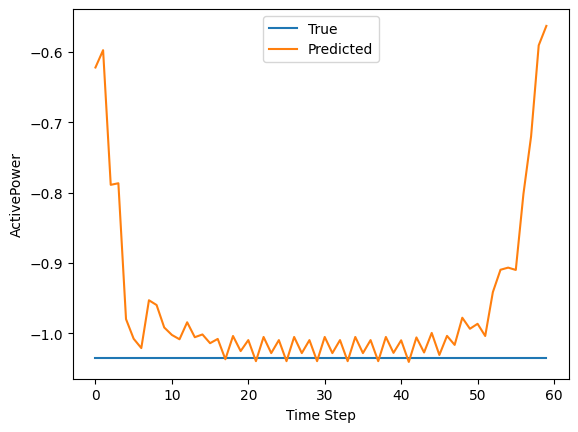

In [29]:
plt.plot(x_train[0], label='True')
plt.plot(x_train_pred[0], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('ActivePower')
plt.legend()
plt.show()

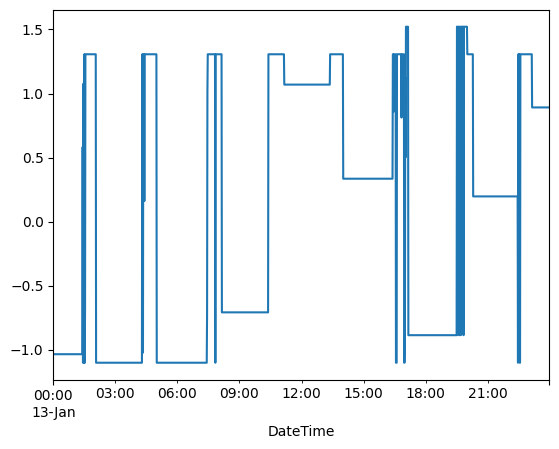

Test input shape:  (1381, 60, 1)
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


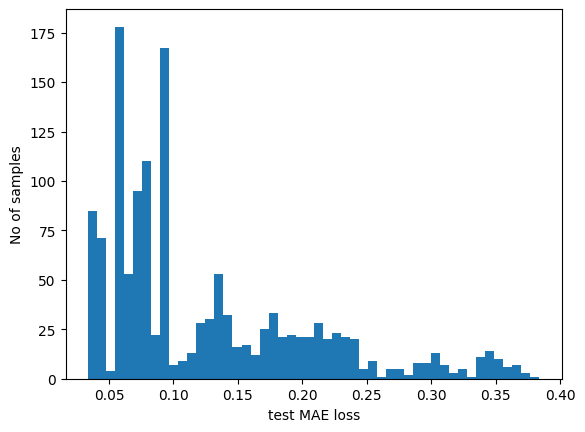

Number of anomaly samples:  345
Indices of anomaly samples:  (array([  33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,  204,  206,  207,  208,  209,  210,  211,
        212,  213,  214,  215,  216,  217,  218,  219,  220,  221,  223,
        224,  225,  226,  227,  228,  229,  230,  231,  232,  233,  234,
        235,  236,  237,  238,  239,  240,  241,  242,  243,  244,  245,
        246,  247,  248,  249,  250,  251,  252,  253,  254,  255,  256,
        257,  258,  259,  260,  414,  415,  416,  417,  418,  419,  420,
        421,  422,  423,  424,  426,  428,  430,  431,  432,  433,  434,
        435,  436,  437,  438,  439,  440,  441,  442,  443,  

In [30]:
df_test_value = (df_test - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values, TIME_STEPS)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


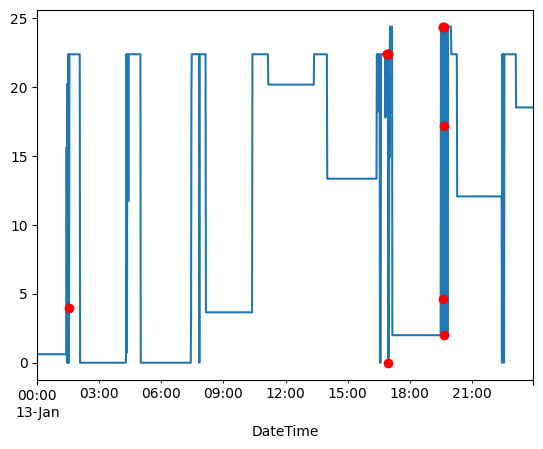

In [31]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

df_subset = df_test.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax, style='-')
if len(df_subset) > 0:
    df_subset.plot(legend=False, ax=ax, style=' ', marker='o', color='r')
plt.show()

In [32]:
# export model
model.export('model.tf')

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


Saved artifact at 'model.tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name=None)
Captures:
  136134716826128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136134708292560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136134708990544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136134708995152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136134708993424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136134708991696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136134708993616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136134708992848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136134708988240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136134708994384: TensorSpec(shape=(), dtype=tf.resource, name=None)
